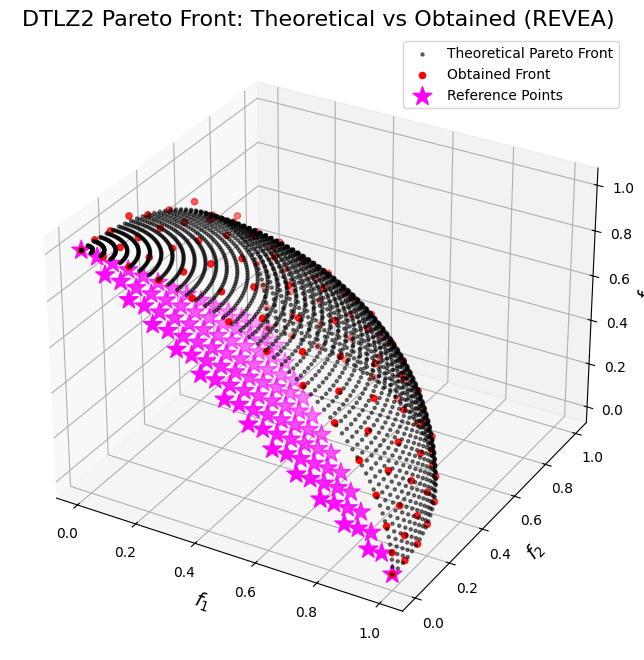

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pymoors import (
    Revea,
    DanAndDenisReferencePoints,
    RandomSamplingFloat,
    GaussianMutation,
    SimulatedBinaryCrossover,
    CloseDuplicatesCleaner,
    Constraints
)
from pymoors.schemas import Population
from pymoors.typing import TwoDArray

np.seterr(invalid="ignore")


def evaluate_dtlz2(x: TwoDArray) -> TwoDArray:
    """
    Evaluate the DTLZ2 objectives for a 3-objective problem.

    The decision vector x has num_vars components. For the Pareto front,
    the auxiliary function g(x) is minimized (g(x)=0) by setting the last
    num_vars-2 variables to 0.5.

    The objectives are computed as:
      f1(x) = (1+g) * cos((pi/2)*x1) * cos((pi/2)*x2)
      f2(x) = (1+g) * cos((pi/2)*x1) * sin((pi/2)*x2)
      f3(x) = (1+g) * sin((pi/2)*x1)
    """
    # Compute the auxiliary function g(x) using variables 3 to num_vars.
    g = np.sum((x[:, 2:] - 0.5) ** 2, axis=1)
    f1 = (1 + g) * np.cos((np.pi / 2) * x[:, 0]) * np.cos((np.pi / 2) * x[:, 1])
    f2 = (1 + g) * np.cos((np.pi / 2) * x[:, 0]) * np.sin((np.pi / 2) * x[:, 1])
    f3 = (1 + g) * np.sin((np.pi / 2) * x[:, 0])
    return np.column_stack((f1, f2, f3))


def dtlz2_theoretical_front(num_points=50):
    """
    Compute a set of points approximating the theoretical Pareto front for DTLZ2 (3 objectives).

    For the Pareto-optimal front, g(x) = 0, which implies that the decision variables
    x_3, ..., x_n are fixed at 0.5. Therefore, the front can be generated by varying x1 and x2:
      f1 = cos((pi/2)*x1) * cos((pi/2)*x2)
      f2 = cos((pi/2)*x1) * sin((pi/2)*x2)
      f3 = sin((pi/2)*x1)
    These points lie on a portion of the unit hypersphere in the positive orthant.
    """
    x1 = np.linspace(0, 1, num_points)
    x2 = np.linspace(0, 1, num_points)
    X1, X2 = np.meshgrid(x1, x2)
    X1_flat = X1.flatten()
    X2_flat = X2.flatten()

    f1 = np.cos((np.pi / 2) * X1_flat) * np.cos((np.pi / 2) * X2_flat)
    f2 = np.cos((np.pi / 2) * X1_flat) * np.sin((np.pi / 2) * X2_flat)
    f3 = np.sin((np.pi / 2) * X1_flat)
    return f1, f2, f3


# Create the reference points using DanAndDenisReferencePoints.
# This object generates reference points for NSGA-III.
ref_points = DanAndDenisReferencePoints(n_reference_points=100, n_objectives=3).generate()

# Set up the REVEA algorithm for DTLZ2.
# For DTLZ2, a typical choice is num_vars = (number of objectives - 1) + k.
# Here, we choose k = 10, so num_vars = 2 + 10 = 12.
algorithm = Revea(
    sampler=RandomSamplingFloat(min=0, max=1),
    crossover=SimulatedBinaryCrossover(distribution_index=10),
    mutation=GaussianMutation(gene_mutation_rate=0.1, sigma=0.01),
    fitness_fn=evaluate_dtlz2,
    constraints_fn=Constraints(lower_bound=0.0, upper_bound=1.0),
    duplicates_cleaner=CloseDuplicatesCleaner(epsilon=1e-8),
    num_vars=12,
    population_size=200,
    num_offsprings=200,
    num_iterations=600,
    mutation_rate=0.1,
    crossover_rate=0.9,
    keep_infeasible=False,
    reference_points=ref_points,
    verbose=False,
    alpha=2.5,
    frequency=0.2,
    seed=1729,
)

# Run the algorithm
algorithm.run()

# Get the best Pareto front obtained (as a Population instance)
best: Population = algorithm.population.best_as_population
obtained_fitness = best.fitness  # Shape: (num_solutions, 3)

# Compute the theoretical Pareto front for DTLZ2
f1_theo, f2_theo, f3_theo = dtlz2_theoretical_front(num_points=50)

# Plot the theoretical Pareto front, the obtained front, and the reference points in 3D.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot the theoretical Pareto front as a scatter of many points.
ax.scatter(
    f1_theo,
    f2_theo,
    f3_theo,
    c="k",
    marker=".",
    label="Theoretical Pareto Front",
    alpha=0.5,
)

# Plot the obtained Pareto front from the algorithm.
ax.scatter(
    obtained_fitness[:, 0],
    obtained_fitness[:, 1],
    obtained_fitness[:, 2],
    c="r",
    marker="o",
    label="Obtained Front",
)

# Plot the reference points.
ax.scatter(
    ref_points[:, 0],
    ref_points[:, 1],
    ref_points[:, 2],
    marker="*",
    s=200,
    color="magenta",
    label="Reference Points",
)

ax.set_xlabel("$f_1$", fontsize=14)
ax.set_ylabel("$f_2$", fontsize=14)
ax.set_zlabel("$f_3$", fontsize=14)
ax.set_title("DTLZ2 Pareto Front: Theoretical vs Obtained (REVEA)", fontsize=16)
ax.legend()
plt.show()